In [133]:
# cd to directory where the Frames folder is (cannot be a shortcut ), 
# and create a folder called transferredFrames in the same directory Frames is in

%cd /content/drive/My\ Drive/Colab\ Notebooks/Frames

import tensorflow as tf
import regex as re

tf.compat.v1.disable_eager_execution()

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import random
# from scipy.misc import imresize
# from scipy.misc import imsave, imresize
# import imageio
from scipy.optimize import fmin_l_bfgs_b   # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import warnings
import time

random.seed(1618)
np.random.seed(1618)
#tf.set_random_seed(1618)   # Uncomment for TF1.
tf.random.set_seed(1618)

#tf.logging.set_verbosity(tf.logging.ERROR)   # Uncomment for TF1.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# CONTENT_IMG_PATH = "frame629.jpg"    #TODO: Add this.
STYLE_IMG_PATH = "../../../../000373_1.jpg"     #TODO: Add this.
TRANSFER_ROUNDS = 20 # 100

TOTAL_WEIGHT = 1e-6 #1.0
STYLE_WEIGHT = 1e-6 #1.0
CONTENT_WEIGHT = 2.5e-8 #0.3


CONTENT_IMG_H = 256 #500
CONTENT_IMG_W = 256 #500

pathlist = Path('').rglob('*.jpg')
OUTPUT_DIR = '../transferredFrames'


#=============================<Helper Fuctions>=================================
'''
TODO: implement this.
This function should take the tensor and re-convert it to an image.
'''
def deprocessImage(x):
    x = x.reshape((CONTENT_IMG_H, CONTENT_IMG_W, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x



def gramMatrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


#========================<Loss Function Builder Functions>======================

def styleLoss(style, combination):
    # return None   #TODO: implement.
    S = gramMatrix(style)
    C = gramMatrix(combination)
    channels = 3
    size = CONTENT_IMG_H * CONTENT_IMG_W
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


def contentLoss(base, combination):
    return K.sum(K.square(combination - base))


def totalLoss(x):
    # return None   #TODO: implement.
    a = K.square(x[:, :CONTENT_IMG_H - 1, :CONTENT_IMG_W - 1, :] - x[:, 1:, :CONTENT_IMG_W - 1, :])
    b = K.square(x[:, :CONTENT_IMG_H - 1, :CONTENT_IMG_W - 1, :] - x[:, :CONTENT_IMG_H - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

#=========================<Pipeline Functions>==================================

# def getRawData():
#     print("   Loading images.")
#     print("      Content image URL:  \"%s\"." % CONTENT_IMG_PATH)
#     print("      Style image URL:    \"%s\"." % STYLE_IMG_PATH)
#     cImg = load_img(CONTENT_IMG_PATH)
#     tImg = cImg.copy()
#     sImg = load_img(STYLE_IMG_PATH)
#     print("      Images have been loaded.")
#     return ((cImg, CONTENT_IMG_H, CONTENT_IMG_W), (sImg, STYLE_IMG_H, STYLE_IMG_W), (tImg, CONTENT_IMG_H, CONTENT_IMG_W))



def preprocessData(raw):
    img, ih, iw = raw
    img = img_to_array(img)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        resize(img, (ih, iw, 3))
    img = img.astype("float64")
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# using this instead 
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(CONTENT_IMG_H, CONTENT_IMG_W))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

'''
TODO: Allot of stuff needs to be implemented in this function.
First, make sure the model is set up properly.
Then construct the loss function (from content and style loss).
Gradient functions will also need to be created, or you can use K.Gradients().
Finally, do the style transfer with gradient descent.
Save the newly generated and deprocessed images.
'''
def style_transfer():
    contentTensor = K.variable(preprocess_image(currentPath)) 
    styleTensor = K.variable(preprocess_image(STYLE_IMG_PATH))
    genTensor = K.placeholder((1, CONTENT_IMG_H, CONTENT_IMG_W, 3))
    inputTensor = K.concatenate([contentTensor, styleTensor, genTensor], axis=0)
    # model = None   #TODO: implement.


    model = vgg19.VGG19(input_tensor=inputTensor,
                        weights='imagenet', include_top=False)
    

    outputDict = dict([(layer.name, layer.output) for layer in model.layers])
    print("   VGG19 model loaded.")


    loss = K.variable(0.0)
    styleLayerNames = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    contentLayerName = outputDict['block5_conv2']
    print("   Calculating content loss.")
    contentOutput = contentLayerName[0, :, :, :]
    genOutput = contentLayerName[2, :, :, :]
    # loss += None   #TODO: implement.
    loss = loss + CONTENT_WEIGHT * contentLoss(contentOutput, genOutput)

    for layerName in styleLayerNames:
        layer_output = outputDict[layerName]
        style_reference_output = layer_output[1, :, :, :]
        gen_style_output = layer_output[2, :, :, :]
        sl = styleLoss(style_reference_output, gen_style_output)
        loss = loss + (STYLE_WEIGHT / len(styleLayerNames)) * sl
    # loss += None   #TODO: implement.
    loss = loss + TOTAL_WEIGHT * totalLoss(genTensor)

    # TODO: Setup gradients or use K.gradients().
    grads = K.gradients(loss, genTensor)

    outputs = [loss]
    outputs += grads

    f_outputs = K.function([genTensor], outputs)
    def eval_loss_and_grads(x):
        x = x.reshape((1, CONTENT_IMG_H, CONTENT_IMG_W, 3))
        outs = f_outputs([x])
        loss_value = outs[0]
        if len(outs[1:]) == 1:
            grad_values = outs[1].flatten().astype('float64')
        else:
            grad_values = np.array(outs[1:]).flatten().astype('float64')
        return loss_value, grad_values

    # fmin_l_bfgs_b needs function for loss and gradients
    # can't call and save value from compute_loss_and_grads
    # calling compute_loss_and_grads twice is inefficient
    # create class for this
    class LossAndGrads(object):
        def loss(self, x):
            lossVal, gradVal = eval_loss_and_grads(x)
            self.lossVal = lossVal
            self.gradVal = gradVal
            return self.lossVal

        def grads(self, x):
            return self.gradVal


    lossAndGrads = LossAndGrads()

    x = preprocess_image(currentPath)




    for i in range(TRANSFER_ROUNDS):
        print("   Step %d." % i)
        #TODO: perform gradient descent using fmin_l_bfgs_b.
        start_time = time.time()
        x, tLoss, info = fmin_l_bfgs_b(lossAndGrads.loss, x.flatten(), fprime=lossAndGrads.grads, maxfun=20, maxiter=20)
        print("      Loss: %f." % tLoss)
        # save current generated image
        img = deprocessImage(x.copy())
        # img = deprocessImage(x)
        # saveFile = None   #TODO: Implement.


        if i == 19:
          saveFile = OUTPUT_DIR + '/' + currentPath  #+ 'round_%d.png' % i
          save_img(saveFile, img)
          print("      Image saved to \"%s\"." % saveFile)


        #imsave(saveFile, img)   #Uncomment when everything is working right.
        end_time = time.time()
        
        print('Iteration %d completed in %ds' % (i, end_time - start_time))
    print("   Transfer complete.")
#=========================<Main>================================================


def main():
    K.clear_session()
    print("Starting style transfer program.")
    # raw = getRawData()
    # cData = preprocessData(raw[0])   # Content image.
    # sData = preprocessData(raw[1])   # Style image.
    # tData = preprocessData(raw[2])   # Transfer image.
    # styleTransfer(cData, sData, tData)

    # for image in IMAGE_DIR:
    #   CONTENT_IMG_PATH = image
    #   style_transfer()

    global currentPath
    currentPath = 'frame348.jpg'
    style_transfer()

    # global currentPath
    # for path in pathlist:
    #   filename = str(path)
    #   regex = re.compile(r'\d+')
    #   num = int(regex.findall(filename)[0])
    #   if num >= 0 and num <= 10:
    #     currentPath = filename
    #     print(filename)
    #     style_transfer()


    print("Done. Goodbye.")



if __name__ == "__main__":
    main()

/content/drive/My Drive/Colab Notebooks/Frames
Starting style transfer program.
   VGG19 model loaded.
   Calculating content loss.
   Step 0.
      Loss: 999.081421.
Iteration 0 completed in 2s
   Step 1.
      Loss: 473.467346.
Iteration 1 completed in 1s
   Step 2.
      Loss: 339.471161.
Iteration 2 completed in 1s
   Step 3.
      Loss: 280.495605.
Iteration 3 completed in 1s
   Step 4.
      Loss: 250.831665.
Iteration 4 completed in 1s
   Step 5.
      Loss: 229.551361.
Iteration 5 completed in 1s
   Step 6.
      Loss: 213.810425.
Iteration 6 completed in 1s
   Step 7.
      Loss: 202.994720.
Iteration 7 completed in 1s
   Step 8.
      Loss: 194.647141.
Iteration 8 completed in 1s
   Step 9.
      Loss: 188.198486.
Iteration 9 completed in 1s
   Step 10.
      Loss: 182.898315.
Iteration 10 completed in 1s
   Step 11.
      Loss: 178.577209.
Iteration 11 completed in 1s
   Step 12.
      Loss: 174.590958.
Iteration 12 completed in 1s
   Step 13.
      Loss: 171.379807.
Iterati

In [134]:
import cv2

# %cd /content/

file_name = "download_16.png"
# file_name = "outline-3 (1).png" 


src = cv2.imread(file_name, 1)
tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
# _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
_,alpha = cv2.threshold(tmp, 240, 255, cv2.THRESH_BINARY_INV)
b, g, r = cv2.split(src)
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)
cv2.imwrite("test.png", dst)

/content


True

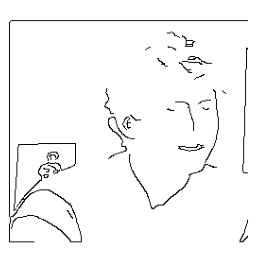

In [129]:
from IPython.display import Image

# %cd /content/
Image('download_16.png')

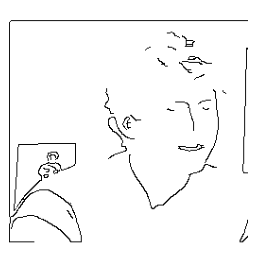

In [139]:
from IPython.display import Image

# %cd /content/
Image('test.png')

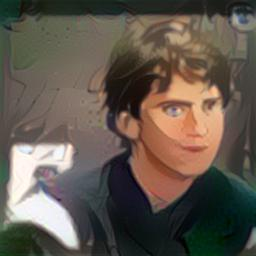

In [142]:
from IPython.display import Image
Image('frame348 (1).jpg')

In [144]:
# layer
from PIL import Image

# ensure they are RGB (not palette)
bg = Image.open('frame348 (1).jpg').convert('RGB')
fg = Image.open('test.png').convert('RGBA') #result-trans.png

# Resize foreground 
fg_resized = fg.resize((256,256))

# Overlay foreground onto background at top right corner
bg.paste(fg_resized,box=(0,0),mask=fg_resized)

bg.save('result-blend.png')

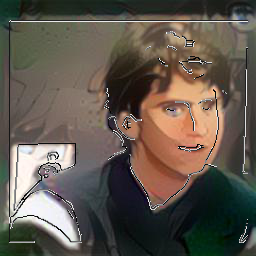

In [145]:
from IPython.display import Image
Image('result-blend.png')
# Image('frame-output.png')